In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import editdistance
import traceback
import cProfile
import pickle

### Data

In [ ]:
from data_icdar2013 import GTUtility
gt_util_train = GTUtility('data/ICDAR2013/')
gt_util_test = GTUtility('data/ICDAR2013/', test=True)
gt_util = GTUtility.merge(gt_util_train, gt_util_test)

print(gt_util)

In [2]:
from data_synthtext import GTUtility
#gt_util = GTUtility('data/SynthText/', polygon=True)

file_name = 'gt_util_synthtext_seglink.pkl'
#pickle.dump(gt_util, open(file_name,'wb'))
with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)

print(gt_util)

Background              0
Text              7266338

images             858749
objects           7266338
per image            8.46
no annotation           0



### Model and Training

In [7]:
from keras.optimizers import SGD, Adam

from crnn_model import CRNN
from crnn_data import InputGenerator
from crnn_data import crop_words
from crnn_utils import alphabet87 as alphabet
from crnn_utils import decode
from ssd_training import Logger

input_width = 256
input_height = 32
batch_size = 128

experiment = 'crnn_synthtext'

checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

model, model_pred = CRNN((input_width, input_height, 1), len(alphabet))

model.load_weights('./models/crnn_synthtext140k.hdf5')

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#optimizer = Adam(lr=0.02, epsilon=0.001, clipnorm=1.)

# dummy loss, loss is computed in lambda layer
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

#model.summary()

max_string_len = model_pred.output_shape[1]

gt_util_train, gt_util_val = GTUtility.split(gt_util, split=0.8)
gen = InputGenerator(gt_util_train, gt_util_val, batch_size, 
                     alphabet=alphabet, input_size=(input_width, input_height), 
                     grayscale=True, max_string_len=max_string_len)

model.fit_generator(generator=gen.generate(train=True), # batch_size here?
                    steps_per_epoch=gen.gt_util_train.num_objects // batch_size,
                    epochs=100,
                    validation_data=gen.generate(train=False), # batch_size here?
                    validation_steps=gen.gt_util_val.num_objects // batch_size,
                    callbacks=[
                        keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5',
                        Logger(checkdir)
                    ],
                    initial_epoch=0)

Epoch 1/100
NEW epoch
   24/45625 [..............................] - ETA: 20174s - loss: 1.3256

KeyboardInterrupt: 

In [ ]:
#model.save_weights('crnn_synthtext140k.hdf5')

In [10]:
from crnn_metric import levnshtein

gen_train = gen.generate(train=True)
gen_test = gen.generate(train=False)

(7, 8)


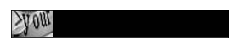

>your                >your                >__y__o_u_r___________________________________________________ 0.00


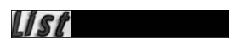

List                 List                 L___i___s____t________________________________________________ 0.00


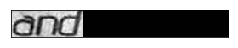

and                  and                  a______n______d_______________________________________________ 0.00


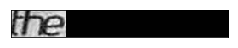

the                  the                  t__h_____e____________________________________________________ 0.00


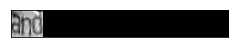

and                  and                  a_n___d_______________________________________________________ 0.00


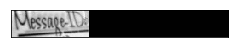

Message-ID:          Message-ID:          M____es_ssagge--IIDD_________________________________________: 0.00
(7, 8)


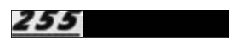

255                  255                  2_______5_____5_______________________________________________ 0.00


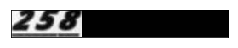

258                  258                  2_______5______8______________________________________________ 0.00


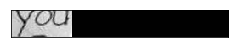

you                  you                  y______o____u_________________________________________________ 0.00


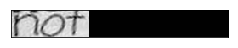

not                  not                  n_________o______t____________________________________________ 0.00


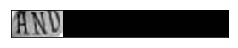

and                  and                  a_____n____d__________________________________________________ 0.00


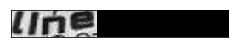

line                 line                 l____i___n_______e____________________________________________ 0.00


In [12]:
n = 200
for j in range(n,n+2):
    
    img_path = os.path.join(gt_util.image_path, gt_util.image_names[j])
    img = cv2.imread(img_path)
    #mean = np.array([104,117,123])
    #img -= mean[np.newaxis, np.newaxis, :]
    boxes = np.copy(gt_util.data[j][:,:-gt_util.num_classes])
    texts = np.copy(gt_util.text[j])
    print(boxes.shape)
    boxes_mask = np.array([not (np.any(b < 0) or np.any(b > 0)) for b in boxes])
    boxes = boxes[boxes_mask]
    texts = texts[boxes_mask]
    
    words = crop_words(img, boxes, input_height, width=input_width, grayscale=True)
    words = np.asarray([w.transpose(1,0,2) for w in words])
    res = model_pred.predict(words)
        
    for i in range(len(res)):
        chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]

        img = words[i][:,:,0].T
        plt.figure(figsize=[30,0.5])
        plt.imshow(img, cmap='gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()

        gt_str = texts[i]
        res_str = decode(chars)

        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        #mean_ed += ed
        #mean_ed_norm += ed_norm

        print('%-20s %-20s %s %0.2f' % (
            gt_str,
            res_str,
            ''.join(chars),
            ed_norm))

In [13]:
# generated input
for j in range(10):
    print('batch', j)
    g = next(gen_test)
    for i in range(batch_size):
        print('%-10s %-3s %-3s %-10s %-10s' % (
            g[0]['image_input'][i].shape, 
            int(g[0]['input_length'][i][0]), 
            int(g[0]['label_length'][i]),
            g[0]['source_str'][i],
            np.asarray(g[0]['label_input'][i], dtype=int),
            ))

batch 0
NEW epoch
(256, 32, 1) 62  4   with       [22  8 19  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  4   disc       [ 3  8 18  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  2   to         [19 14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  7   ground.    [ 6 17 14 20 13  3 66 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  3   the        [19  7  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

(256, 32, 1) 62  3   MLB        [38 37 27 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  6   Lines:     [37  8 13  4 18 68 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  3   off        [14  5  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  4   know       [10 13 14 22 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  3   the        [19  7  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 

(256, 32, 1) 62  11  Newsgroups: [39  4 22 18  6 17 14 20 15 18 68 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  5   right      [17  8  6  7 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  3   say        [18  0 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  4   more       [12 14 17  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  4   must       [12 20 18 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1

 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  3   >by        [81  1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  4   pull       [15 20 11 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  4   time       [19  8 12  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  3   >of        [81 14  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  2   or         [14 17 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

(256, 32, 1) 62  3   how        [ 7 14 22 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  6   peace,     [15  4  0  2  4 67 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  4   Gulf       [32 20 11  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  5   after      [ 0  5 19  4 17 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(256, 32, 1) 62  4   Have       [33  0 21  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 

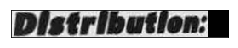

Distribution:        Distribution:        D_______i__s____t___r____i__b____u_____t___i__o___n_________:: 0.00


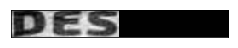

DES                  DES                  D___________E_________S_______________________________________ 0.00


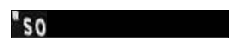

"so                  "so                  "__s___o______________________________________________________ 0.00


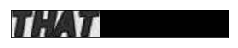

that                 that                 t_____h_______a_____t_________________________________________ 0.00


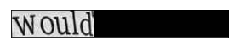

would                would                w_______o___u____l__d_________________________________________ 0.00


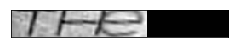

the                  the                  t____________h_____________e__________________________________ 0.00


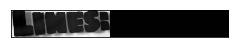

Lines:               Lines:               L_____i___n_____e____s_______________________________________: 0.00


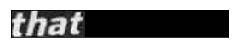

that                 that                 t___h______a_____t____________________________________________ 0.00


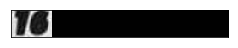

16                   16                   1_____6_______________________________________________________ 0.00


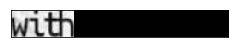

with                 with                 w____iii_tt___h_______________________________________________ 0.00


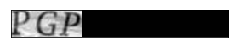

PGP                  PGP                  P_______G______P______________________________________________ 0.00


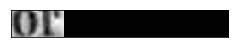

or                   or                   o________r____________________________________________________ 0.00


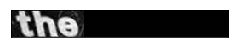

the                  the                  t______h______e_______________________________________________ 0.00


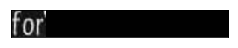

for                  for                  f__o___r______________________________________________________ 0.00


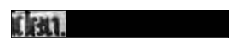

idea.                idem.                id____e__m___________________________________________________. 0.20


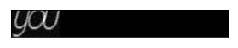

you                  you                  y____o___u____________________________________________________ 0.00


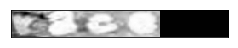

race                 rsce                 r__________s___________c__________e___________________________ 0.25


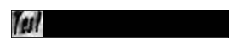

Test                 Test                 T__e_s_t______________________________________________________ 0.00


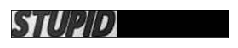

STUPID               StuPId               S_____t___u______P____I__d____________________________________ 0.50


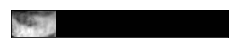

other                F                    F_____________________________________________________________ 1.00


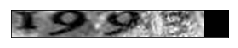

1993                 1993                 1_________9_______________9__________________3________________ 0.00


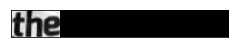

the                  the                  t___h____e____________________________________________________ 0.00


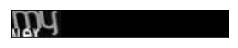

my                   my                   m_______y_____________________________________________________ 0.00


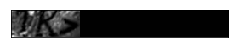

TK>                  TK>                  T______K______>_______________________________________________ 0.00


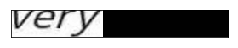

very                 very                 v_____e______rr____y__________________________________________ 0.00


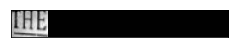

THE                  THE                  T_H____E______________________________________________________ 0.00


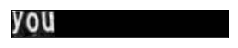

you                  you                  y___o___u_____________________________________________________ 0.00


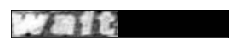

wait                 wait                 w___________a_______i_____t___________________________________ 0.00


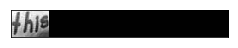

this                 this                 t__h__i_s_____________________________________________________ 0.00


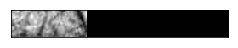

TK>                  the                  t________h______e_____________________________________________ 1.00


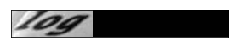

log                  log                  l_______o_____g_______________________________________________ 0.00


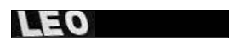

LEO                  LEO                  L________E______O_____________________________________________ 0.00


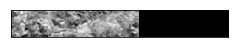

How                  Lom                  L_________o_____________m_____________________________________ 0.67


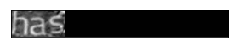

has                  has                  h____a_____s__________________________________________________ 0.00


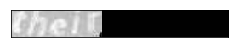

their                their                t____h_____e_____i____r_______________________________________ 0.00


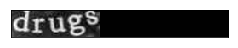

drugs                drugs                d_____r___u_____g____s________________________________________ 0.00


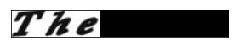

The                  The                  T__________h_______e__________________________________________ 0.00


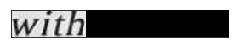

with                 with                 w_______ii__tt__h_____________________________________________ 0.00


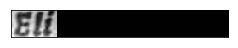

Eli                  Eli                  E_____l___i___________________________________________________ 0.00


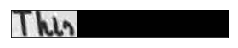

This                 This                 T______h____i__s______________________________________________ 0.00


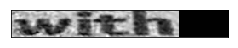

with                 with                 w__________________i_____tt_________hh________________________ 0.00


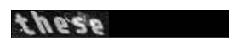

these                these                t______h____e_____s____e______________________________________ 0.00


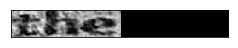

the                  the                  t_________h__________e________________________________________ 0.00


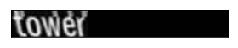

tower                tower                tt__o____w_____e___r__________________________________________ 0.00


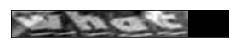

what                 what                 w_________________h__________a___________t____________________ 0.00


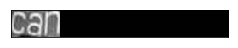

can                  can                  c____a___n____________________________________________________ 0.00


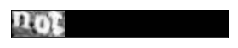

not                  not                  n_____o_____t_________________________________________________ 0.00


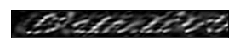

Cambridge,           Oeriarg:             O_________________e_________r__________i____a_____r___g______: 0.80


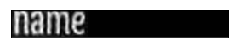

name                 name                 n_____a___m_______e___________________________________________ 0.00


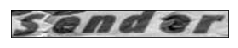

Sender:              Sender:              S___________e_________n_________d___________e________rr______: 0.00


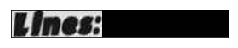

Lines:               Lines:               L_____i__n_____e____s________________________________________: 0.00


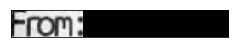

From:                From:                F___r___o___m________________________________________________: 0.00


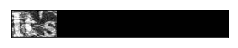

It's                 It's                 I___t_'''s____________________________________________________ 0.00


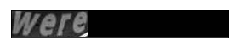

were                 were                 w_______e_____r___e___________________________________________ 0.00


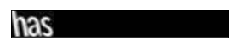

has                  has                  h____a___s____________________________________________________ 0.00


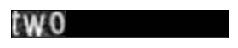

two                  two                  t__w_______o__________________________________________________ 0.00


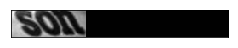

son                  son                  s_______o_____n_______________________________________________ 0.00


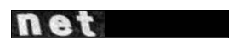

net                  net                  n__________e________t_________________________________________ 0.00


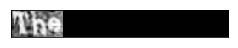

The                  The                  TT____h___e___________________________________________________ 0.00


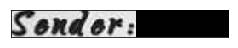

Sender:              Sender:              S______e____n____d_____e____r________________________________: 0.00


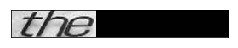

the                  the                  t________h______ee____________________________________________ 0.00


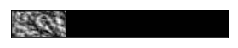

get                  get                  g______e____t_________________________________________________ 0.00


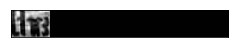

the                  the                  t_h___e_______________________________________________________ 0.00


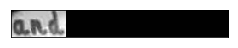

and                  and                  a____n_____d__________________________________________________ 0.00


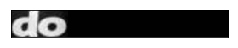

do                   do                   d_______o_____________________________________________________ 0.00


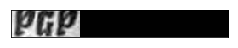

PGP                  PGP                  P______G______P_______________________________________________ 0.00


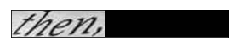

then,                then,                tt____h_____e_____n__________________________________________, 0.00


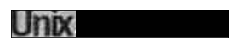

Unix                 Unix                 U_____n____ii_x_______________________________________________ 0.00


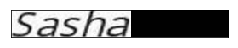

Sasha                Sasha                S_______a______s_____h_______a________________________________ 0.00


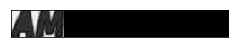

am                   Am                   A_______m_____________________________________________________ 0.50


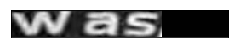

was                  was                  w____________________a___________s____________________________ 0.00


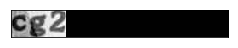

cg2                  cg2                  c____g_____2__________________________________________________ 0.00


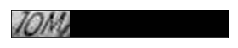

10m                  10M                  1____0___M____________________________________________________ 0.33


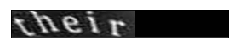

their                their                t______h______e_______i_____r_________________________________ 0.00


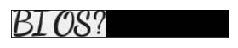

BIOS?                BIOS?                BB_____I_____O_____S____?_____________________________________ 0.00


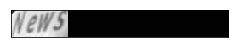

News                 News                 N___e__w_____s________________________________________________ 0.00


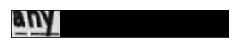

any                  any                  a___n____y____________________________________________________ 0.00


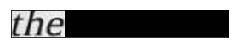

the                  the                  t___h_____e___________________________________________________ 0.00


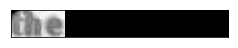

the                  the                  t___h_____e___________________________________________________ 0.00


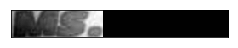

MS.                  MS.                  M_____________S______________________________________________. 0.00


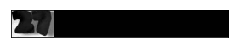

27                   27                   2______7______________________________________________________ 0.00


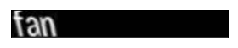

fan                  fan                  f___a___n_____________________________________________________ 0.00


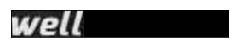

well                 well                 w_______e_____l___l___________________________________________ 0.00


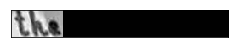

the                  the                  t____h_____e__________________________________________________ 0.00


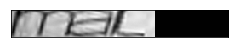

mail                 mal                  mm________________a___________l_______________________________ 0.25


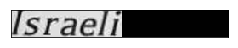

Israeli              Israeli              I___s____r____a_____e____l___ii_______________________________ 0.00


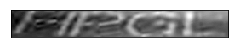

HPGL                 HPGl                 H_________________P_________________G_____________l___________ 0.25


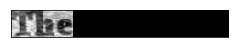

The                  The                  TT_____h_____e________________________________________________ 0.00


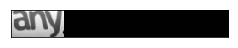

any                  any                  a____n____yy__________________________________________________ 0.00


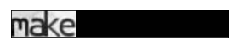

make                 make                 m____a___k____e_______________________________________________ 0.00


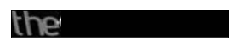

the                  the                  t___h____e____________________________________________________ 0.00


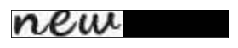

new                  new                  n___________e_______w_________________________________________ 0.00


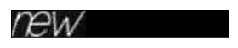

new                  new                  n_____e_____w_________________________________________________ 0.00


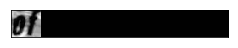

of                   of                   o____f________________________________________________________ 0.00


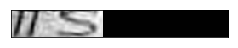

it's                 it's                 i___t______'___s______________________________________________ 0.00


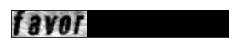

favor                favor                f____a___v____o___r___________________________________________ 0.00


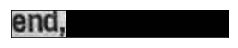

end,                 end,                 e___n____d___________________________________________________, 0.00


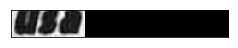

usa                  usa                  u_______s_____a_______________________________________________ 0.00


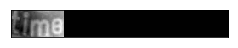

time                 time                 t_ii_m_____e__________________________________________________ 0.00


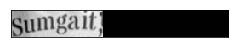

Sumgait,             Sumgait,             S__u___m_____g__a___i__t_____________________________________, 0.00


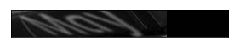

May                  May                  M________________a______y_____________________________________ 0.00


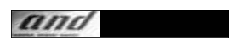

and                  and                  a_________n______d____________________________________________ 0.00


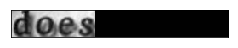

does                 does                 d______o_____e______s_________________________________________ 0.00


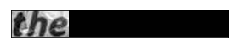

the                  the                  t____h_____e__________________________________________________ 0.00


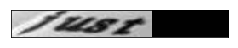

just                 just                 jj____________u_________s_______t_____________________________ 0.00


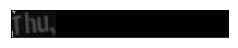

Thu,                 Thu,                 T__h___u_____________________________________________________, 0.00


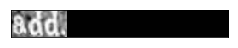

add.                 add.                 a____d___d___________________________________________________. 0.00


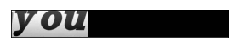

you                  you                  y________o_____u______________________________________________ 0.00


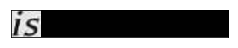

is                   is                   i___s_________________________________________________________ 0.00


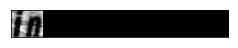

in                   in                   i___n_________________________________________________________ 0.00


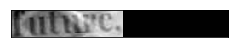

future,              future.              f____u_____t___u____r____e___________________________________. 0.14


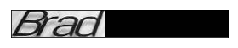

Brad                 Brad                 B________r___a_____d__________________________________________ 0.00


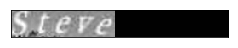

Steve                Steve                S______tt____e_____v_____e____________________________________ 0.00


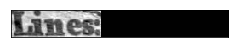

Lines:               Lines:               L_____i___n_____e____s_______________________________________: 0.00


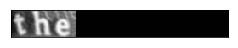

the                  the                  t_____h_____e_________________________________________________ 0.00


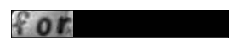

for                  for                  f______o_____r________________________________________________ 0.00


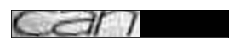

Can                  can                  c___________a____________n____________________________________ 0.33


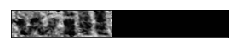

will                 will                 w_____________ii____l___ll____________________________________ 0.00


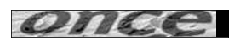

once                 once                 o__________________n____________cc___________e________________ 0.00


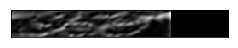

955                  360                  3_______________6___________0_________________________________ 1.00


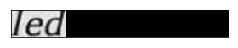

led                  led                  l___e_____d___________________________________________________ 0.00


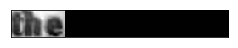

the                  the                  t___h_____e___________________________________________________ 0.00


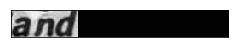

and                  and                  a______n_____d________________________________________________ 0.00


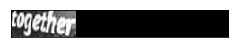

together             together             to_g__e_t_h__e__r_____________________________________________ 0.00


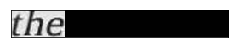

the                  the                  t___h_____e___________________________________________________ 0.00


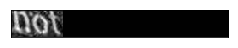

not                  not                  n_____o____t__________________________________________________ 0.00


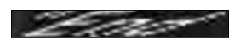

"End                 Eind:                E_________________________i___n_______d______________________: 0.75


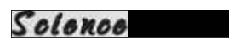

Science              Science              S______c____i__e____n____c____e_______________________________ 0.00

mean editdistance: 0.273
mean normalized editdistance: 0.062


In [14]:
#g = next(gen_train)
g = next(gen_test)

res = model_pred.predict(g[0]['image_input'])

mean_ed = 0
mean_ed_norm = 0

for i in range(len(res)):
    # best path, real ocr applications use beam search with dictionary and language model
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    
    img = g[0]['image_input'][i][:,:,0].T
    plt.figure(figsize=[30,0.5])
    plt.imshow(img, cmap='gray')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
    
    gt_str = g[0]['source_str'][i]
    res_str = decode(chars)
    
    ed = editdistance.eval(gt_str, res_str)
    #ed = levenshtein(gt_str, res_str)
    ed_norm = ed / len(gt_str)
    mean_ed += ed
    mean_ed_norm += ed_norm
    
    print('%-20s %-20s %s %0.2f' % (
        gt_str,
        res_str,
        ''.join(chars),
        ed_norm))

mean_ed /= len(res)
mean_ed_norm /= len(res)

print('\nmean editdistance: %0.3f\nmean normalized editdistance: %0.3f' % (mean_ed, mean_ed_norm))

In [16]:
%%timeit
res = model_pred.predict(g[0]['image_input'][1,None])
for i in range(len(res)):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    res_str = decode(chars)

27 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
p = cProfile.Profile()
p.enable()


p.disable()
p.print_stats(sort='time')